In [418]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [419]:
##clear null prices
def SelectModel(pathfile,modelname):
    df = pd.read_csv(pathfile)
    return df[df['model_name'].isin([modelname])].reset_index(drop=True).drop(['feature_1','feature_2','feature_3','feature_4','feature_5','feature_6','feature_7','feature_8','feature_9','duration_listed','engine_has_gas','engine_type','has_warranty','is_exchangeable','location_region','number_of_photos','body_type','up_counter','feature_0','manufacturer_name','model_name'],axis=1)

def DefiningDFandTarget(df,target): #remove basedf ref
    TargetCol = target
    Y = df[target]
    df.drop(columns=[TargetCol], axis=1,inplace = True)
    basedf = df.insert(0,TargetCol, Y)
    return TargetCol, Y, basedf

In [420]:
DefiningDFandTarget(SelectModel('C:/Users/Gfreitas/Downloads/ModeloPreditivoCarrosUsados/cars.csv','Golf'),'price_usd')

('price_usd',
 0      6300.00
 1      3400.00
 2      2100.00
 3      1480.00
 4      4000.00
         ...   
 702    7000.00
 703    1500.00
 704     350.00
 705     711.37
 706    1850.00
 Name: price_usd, Length: 707, dtype: float64,
 None)

In [421]:
#cardf.info()

In [422]:
#cardf.describe()

<AxesSubplot:xlabel='state', ylabel='price_usd'>

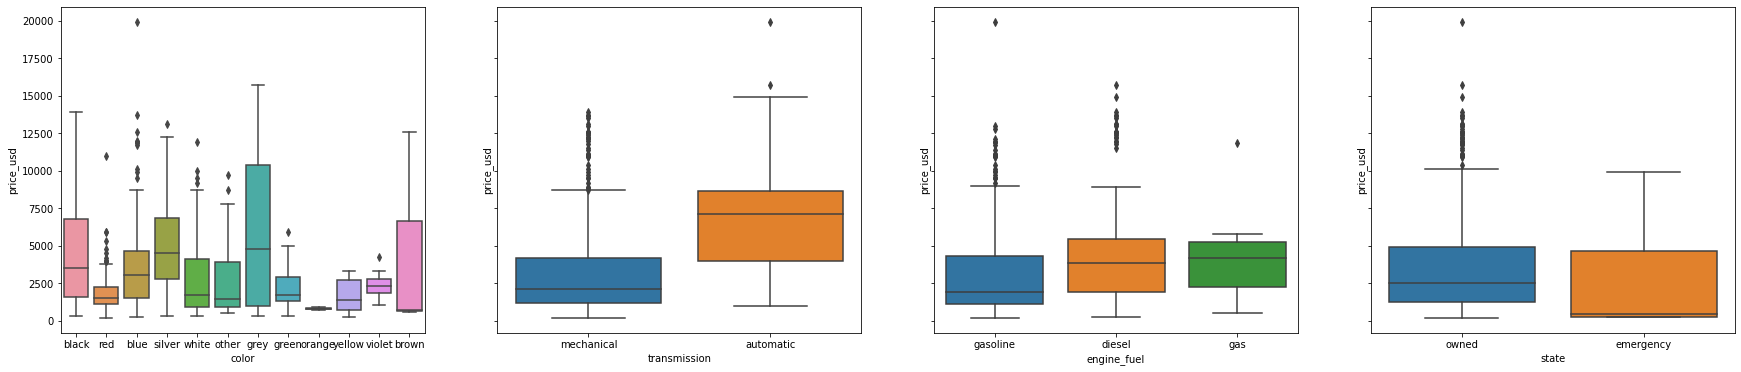

In [423]:
## Pipeline, count number of elements, loop creation
#print(vwjetta_df['drivetrain'].value_counts())
#print(vwjetta_df['state'].value_counts())
#print(vwjetta_df['transmission'].value_counts())
#print(vwjetta_df['color'].value_counts())
#print(vwjetta_df['engine_fuel'].value_counts())
## Show counts on plot
##iteract all columns minus Y
fig, axs = plt.subplots(ncols=4, figsize=(30,6),sharey=True)
sns.boxplot(x='color',y=Y,data=basedf, ax=axs[0])
sns.boxplot(x='transmission',y=Y,data=basedf, ax=axs[1])
sns.boxplot(x='engine_fuel',y=Y,data=basedf, ax=axs[2])
sns.boxplot(x='state',y=Y,data=basedf, ax=axs[3])

In [424]:
def Dummies(df,column):
    return pd.concat([df, pd.get_dummies(df[column])],axis=1).drop(column,axis=1)

In [425]:
#transform all non numeric columns to dummies
cardf = Dummies(basedf,['transmission','state','engine_fuel','drivetrain','color'])

In [426]:
cardf

,price_usd,odometer_value,year_produced,engine_capacity,transmission_automatic,transmission_mechanical,state_emergency,state_owned,engine_fuel_diesel,engine_fuel_gas,...,color_brown,color_green,color_grey,color_orange,color_other,color_red,color_silver,color_violet,color_white,color_yellow
0,6300.00,213000,2001,1.8,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3400.00,260000,1999,1.9,0,1,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,2100.00,280000,1996,1.9,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1480.00,290000,1994,1.6,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4000.00,267000,2000,1.9,1,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,7000.00,200000,2009,1.4,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
703,1500.00,291500,1994,1.9,0,1,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
704,350.00,240000,1983,1.1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
705,711.37,400000,1990,1.6,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [427]:
#cardf.corr()

In [428]:
#Vamos Analisar a significância estatística das variáveis em comparação com o preço (price_usd).
#Neste projeto, p < 0.05 é definido como estatisticamente significante, ou seja, uma confiança de >95% de que a correlação entre os dados é significante, e não uma coincidência.
##adapt to move price column to end and remove from loop
##adapt to create table as result
def CoefPearson(df):
    lcoef = []
    lp = []
    for x in list(df.columns):
        coef, p = stats.pearsonr(df[x],Y)
        lcoef.append(round(coef,2))
        lp.append(round(p,2))
    return pd.DataFrame(lcoef).merge(pd.DataFrame(lp),on=df.columns).rename(columns={'key_0':'Independent Var','0_x':'PearsonCoef','0_y':'P-Value'}).drop([0]).reset_index(drop=True)

def FilterP(df):
    return df[df['P-Value'] <= 0.05].reset_index(drop=True)

In [429]:
CoefPearson(cardf)
#create var with biggest absolute coef to use in SLR

,Independent Var,PearsonCoef,P-Value
0,odometer_value,-0.36,0.00
1,year_produced,0.90,0.00
2,engine_capacity,-0.09,0.02
3,transmission_automatic,0.37,0.00
4,transmission_mechanical,-0.37,0.00
5,state_emergency,-0.02,0.59
6,state_owned,0.02,0.59
7,engine_fuel_diesel,0.17,0.00
8,engine_fuel_gas,0.03,0.46
9,engine_fuel_gasoline,-0.17,0.00


In [430]:
def BiggestAbsCoef(df):
    return df.loc[df['PearsonCoef'].abs().idxmax()]

In [431]:
FilterP(CoefPearson(cardf)) #use only these in MLR

,Independent Var,PearsonCoef,P-Value
0,odometer_value,-0.36,0.00
1,year_produced,0.90,0.00
2,engine_capacity,-0.09,0.02
3,transmission_automatic,0.37,0.00
4,transmission_mechanical,-0.37,0.00
5,engine_fuel_diesel,0.17,0.00
6,engine_fuel_gasoline,-0.17,0.00
7,drivetrain_all,0.13,0.00
8,drivetrain_front,-0.11,0.00
9,color_black,0.14,0.00


In [432]:
BiggestAbsCoef(FilterP(CoefPearson(cardf)))

Independent Var    year_produced
PearsonCoef                  0.9
P-Value                      0.0
Name: 1, dtype: object

In [433]:
#Teste de ANOVA (Analise de Variância)
#O teste de ANOVA testa a significância da variação das médias entre grupos de uma mesma variável.
#Dois parâmetros são observados no teste ANOVA: Teste_F e Valor_P.
#Teste_F: ANOVA assume que a hipótese que a média entre os grupos é a mesma, e quantifica o desvio da média calculada pela média assumida. Quanto maior o Teste_F, maior a diferença entre médias.
#Valor_P: Indica o quão estatisticamente significante é o valor de Teste_F.
###move price column to end and remove from loop
#def Anova(df):
#    for x in list(df.columns):
#        f_val, p_val = stats.f_oneway(df[x],Y)
#        print("ANOVA",x,"x Price: F-Value=", round(f_val,2),"P-Value:", round(p_val,2))
#    return 

#compare in groups of same variable
#Anova(cardf)
#grp_year_produced=vwjetta_df[['year_produced', 'price_usd']].groupby(['year_produced'])
#grp_year_produced.head()

Model Equation: Predicted Price = -687740.0671526314 + ( 346.0436035430563 * Year Produced)


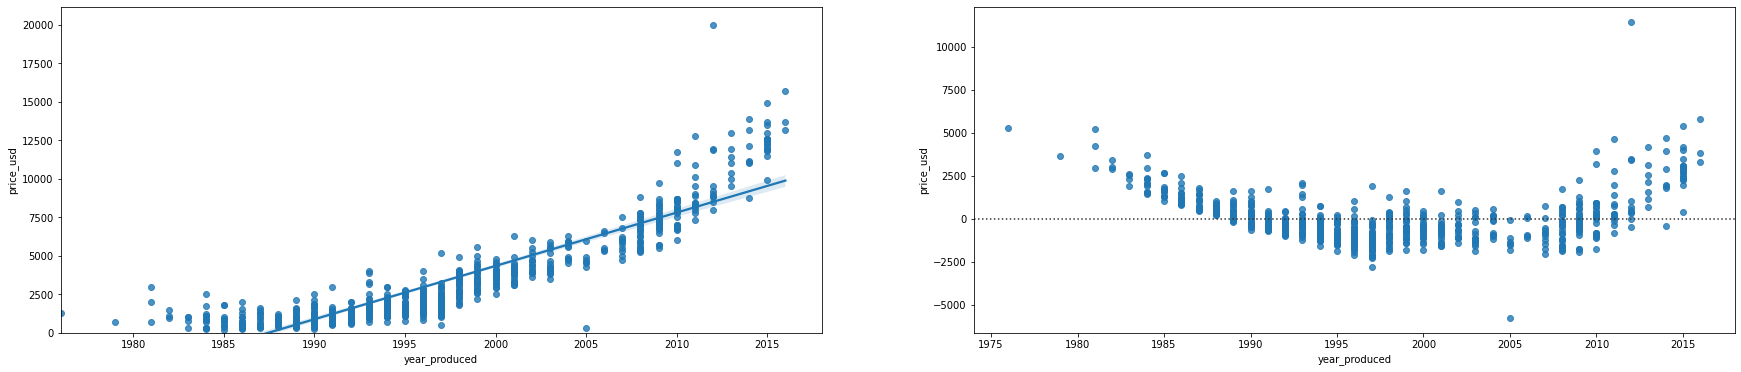

In [434]:
#Regressão Linear Simples + Residual Plot
#define x and X as the best absolute pearson coef
lm = LinearRegression()
x = cardf['year_produced']
X = cardf[['year_produced']]
lm.fit(X,Y)
fig, axs = plt.subplots(ncols=2, figsize=(30,6))
ax0 = sns.regplot(x=X,y=Y,data=cardf,ax=axs[0])
ax1 = sns.residplot(x=X,y=Y,data=cardf,ax=axs[1])
ax0.set_ylim(0,)
ax0.set_xlim(x.min(),)
print('Model Equation: Predicted Price =',lm.intercept_,'+ (',float(lm.coef_),'*','Year Produced)')
#Residual plot shows that linear regression is not a good model (curvy residual)

In [435]:
#Regressão Linear Múltipla
lm1 = LinearRegression()
Z = cardf[['odometer_value','year_produced', 'transmission_automatic','state_emergency']] #adapt to get all but price
lm1.fit(Z,Y)
print("Ponto de Interceptação:",lm1.intercept_)
print("Coeficientes:",lm1.coef_)
print('Equação do Modelo: Preço = ',lm1.intercept_,'+ (',lm1.coef_[0],'*','Odômetro)+(',lm1.coef_[1],'*','Ano Produzido)+(',lm1.coef_[2],'*','Automático? 1-Sim, 0-Não)+(',lm1.coef_[3],'*','Acidentes? 1-Sim, 0-Não)')

Ponto de Interceptação: -665940.7550091271
Coeficientes: [-1.97551359e-04  3.35113360e+02  7.55112185e+02 -2.30703378e+02]
Equação do Modelo: Preço =  -665940.7550091271 + ( -0.00019755135864136245 * Odômetro)+( 335.1133596392353 * Ano Produzido)+( 755.1121847023506 * Automático? 1-Sim, 0-Não)+( -230.7033781225172 * Acidentes? 1-Sim, 0-Não)


(0.0, 23982.84455768286)

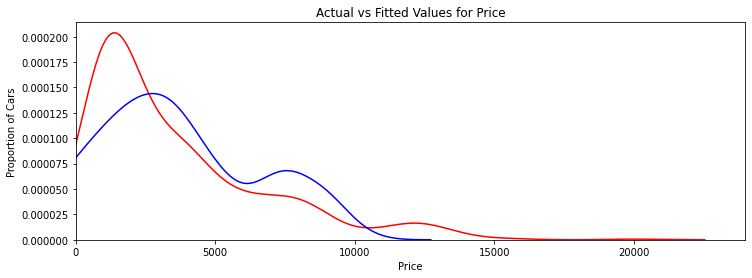

In [436]:
Y_hat = lm1.predict(Z)
plt.figure(figsize=(12,4))
ax1 = sns.kdeplot(Y, color="r", label="Actual Value")
sns.kdeplot(Y_hat, color="b", label="Fitted Values", ax=ax1)

plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price')
plt.ylabel('Proportion of Cars')
plt.xlim(0,)

        3        2
0.1785 x - 1056 x + 2.084e+06 x - 1.371e+09


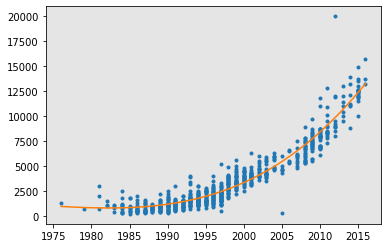

In [437]:
#Regressao Polinomial
def PlotPolly(model, X, Y):
    x_new = np.linspace(x.min(),x.max())
    y_new = model(x_new)
    plt.plot(X, Y, '.', x_new, y_new, '-')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.show()
    plt.close()

p = np.poly1d(np.polyfit(x, Y, 3)) #3 degrees polynomial. can be adjusted further
print(p)
PlotPolly(p, x, Y)

In [438]:
def R2andMSE(realY,predictY):
    print('R2:',r2_score(realY,predictY))
    print('MSE:',mean_squared_error(realY, predictY))
    return

def SLR_Pred(model,independent_variable):
    return round((float((model.coef_*independent_variable)+model.intercept_)),2)

def MLR_Pred(model,independent_variable): #adapt to get independent variables as list and loop
    return round(((model.coef_[0]*Odometro)+(model.coef_[1]*Ano)+(model.coef_[2]*Automatico)+(model.coef_[3]*Acidente)+model.intercept_),2)

def PR_Pred(model,independent_variable): #adapt to get any polinomial and loop
    return round(((model[0])+(model[1]*(independent_variable))+(model[2]*(independent_variable**2))+(model[3]*(independent_variable**3))),2)

In [439]:
##Adapt to be filled automatically, compare predictios, MSE, r2 and select best model automatically
#Predições
Ano = 2010
Odometro = 120000
Automatico = 1
Acidente = 0
Auto = 'Automático' if Automatico==1 else 'Manual'
Ac = 'Acidentado' if Acidente==1 else 'Não Acidentado'
print('SLR predicted price:',SLR_Pred(lm,Ano))
R2andMSE(Y,lm.predict(X))
print('MLR predicted price:',MLR_Pred(lm1,Ano))#change independent variables when adapting function
R2andMSE(Y,lm1.predict(Z))
print('RP predicted price:',PR_Pred(p,Ano))
R2andMSE(Y,p(x))

SLR predicted price: 7807.58
R2: 0.8134058215471239
MSE: 1917327.5345821206
MLR predicted price: 8368.5
R2: 0.8188917567888983
MSE: 1860957.4228283677
RP predicted price: 8356.24
R2: 0.9202584402467222
MSE: 819375.4458641758
